# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

# Defining Constants
Some constants that we will be using so intead of writing them again and again we declare the first.

In [ ]:
CLASS_NAMES=['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
NUM_CLASSES=4
BASE_TRAIN_DIR="/content/drive/MyDrive/Alzheimer_Disease_Prediction_using_CNN/AlzheimerDataset/train"
BASE_TEST_DIR="/content/drive/MyDrive/Alzheimer_Disease_Prediction_using_CNN/AlzheimerDataset/test"
AUTOTUNE=tf.data.experimental.AUTOTUNE
NR_EPOCHS=10

# Preprocessing Our Dataset
Lets explore our data and see how many images we are working with of each type of dementia.

In [ ]:
# Mapping CLASS_NAMES to their corresponding directory names
dir_name_map = {
    'MildDementia': 'MildDemented',
    'ModerateDementia': 'ModerateDemented',
    'NonDementia': 'NonDemented',
    'VeryMildDementia': 'VeryMildDemented'
}

NUM_IMAGES = []  # for keeping record of each type of record
for label in CLASS_NAMES:
    dir_name = dir_name_map[label]
    dir_path = os.path.join(BASE_TRAIN_DIR, dir_name)
    NUM_IMAGES.append(len([name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]))


In [ ]:
print("Number of each type of image in our dataset:")
for label in range(4):
    print(f"{CLASS_NAMES[label]}:{NUM_IMAGES[label]}")

Number of each type of image in our dataset:
MildDementia:10717
ModerateDementia:2823
NonDementia:2560
VeryMildDementia:1792


By viewing the above output we can observe that our dataset is highly imbalanced.As we can see for on type of image we have 2500+ images for other we have only 52 images.<br>
This will greatly hamper the accuracy of our model. So to solve this model we must first balance our dataset a little bit so tha their is not so much difference between or data.<br>
For this we will be using Keras modules <b>ImageDataGenerator()</b> function which is used to pre process image data and also used for generating new data.

In [ ]:

datagen=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
import os

directory = '/content/drive/MyDrive/Alzheimer_Disease_Prediction_using_CNN/AlzheimerDataset/train/MildDemented'
existing_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
existing_files.sort()

for filename in existing_files:
    img_path = os.path.join(directory, filename)
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='/content/drive/MyDrive/Alzheimer_Disease_Prediction_using_CNN/AlzheimerDataset/train/MildDemented', save_prefix='mildDem', save_format='jpg'):
        i += 1
        if i > 2:
            break


In [ ]:
import os

directory = '/content/drive/MyDrive/Alzheimer_Disease_Prediction_using_CNN/AlzheimerDataset/train/MildDemented'
if os.path.exists(directory):
    print("Directory exists")
    files = os.listdir(directory)
    print("Number of files:", len(files))
else:
    print("Directory does not exist")


Directory exists
Number of files: 10717


In [ ]:
NEW_NUM_IMAGES = []
for label in CLASS_NAMES:
    dir_name = os.path.join(BASE_TRAIN_DIR, label[:-2] + "ed")
    num_images = len([name for name in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, name))])
    NEW_NUM_IMAGES.append(num_images)


In [ ]:
print("New dataset with augmented images:")
for label in range(4):

    print(f"{CLASS_NAMES[label]}:{NEW_NUM_IMAGES[label]}")

New dataset with augmented images:
MildDementia:10717
ModerateDementia:2823
NonDementia:2560
VeryMildDementia:1792


Now our data looks fairly balanced as their is not as much marginal gap as before also we have more input images to train with.<br>
Using Keras preprocessing module we will take our image data as input from directory and prepocess our image data at the same time. We will be splitting our dataset into train dataset and validation dataset.

In [ ]:

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TRAIN_DIR,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='training',
    seed=1000
)

Found 17892 files belonging to 4 classes.
Using 14314 files for training.


In [ ]:

val_data=tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TRAIN_DIR,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
)

Found 17892 files belonging to 4 classes.
Using 3578 files for validation.


In [ ]:
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TEST_DIR,
    image_size=(224,224),
    batch_size=32,
    seed=1000
)

Found 1279 files belonging to 4 classes.


In [ ]:
train_data.class_names=CLASS_NAMES
val_data.class_names=CLASS_NAMES

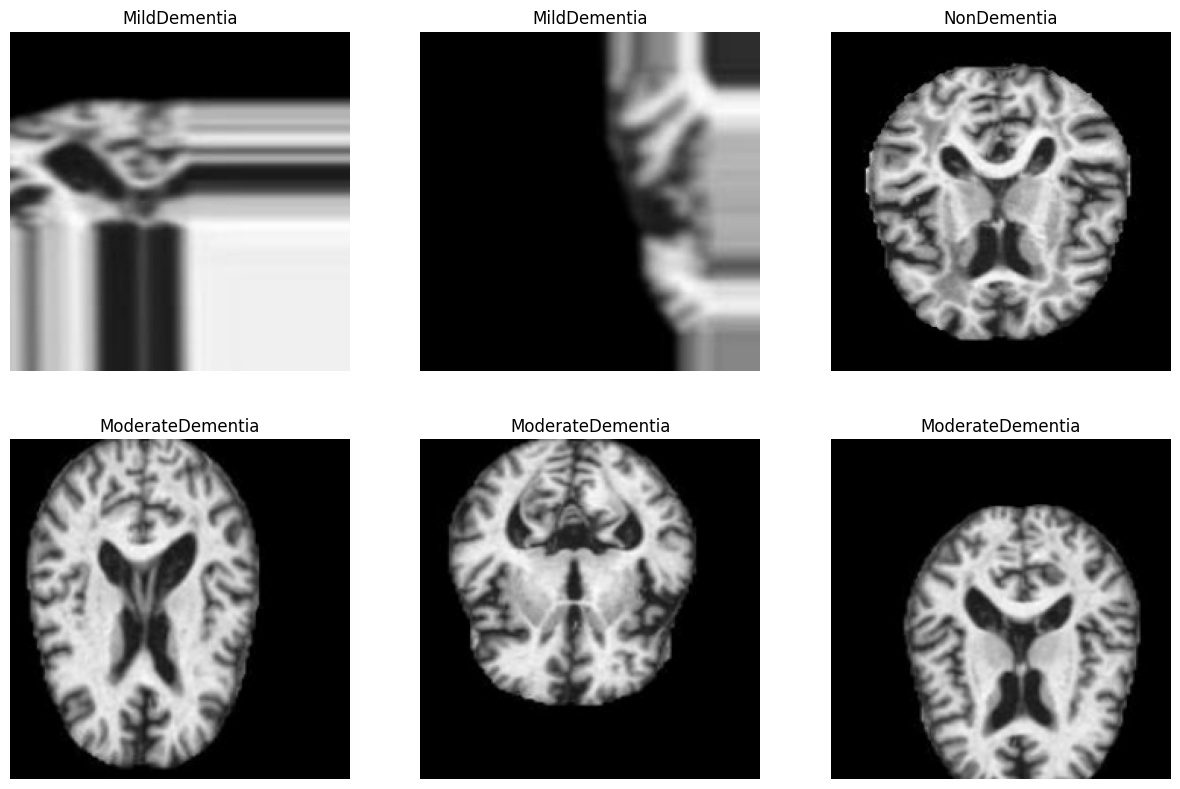

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in train_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]])
        plt.axis("off")
plt.savefig("sample.png")

# Defining our Convolutional Neural Network (CNN)
After preporcessing our data we now come to making oura own CNN model. As weare working with image data it is a no brainer that we will be using a CNN model. We will be using our old friend Keras again to define our own CNN.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional base
base_model.trainable = False

# Create your Sequential model with VGG16 and custom layers
model = Sequential([
    base_model,
    *custom_layers
])


In [ ]:

model = tf.keras.Sequential([
        tf.keras.Input(shape=(224,224, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),

    ])



In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 separable_conv2d (Separabl  (None, 112, 112, 32)      688       
 eConv2D)                                                        
                                                                 
 separable_conv2d_1 (Separa  (None, 112, 112, 32)      1344      
 bleConv2D)                                                      
                                                      

In [ ]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
                )

In [ ]:
model_sum=model.fit(train_data,
                    validation_data=val_data,
                    epochs=NR_EPOCHS)

NameError: name 'model' is not defined

In [ ]:
# Load the test data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TEST_DIR,
    image_size=(224, 224),
    batch_size=32,
    seed=1000
)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.2f}')

In [ ]:
loss_train = model_sum.history['loss']
loss_val = model_sum.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("train_vs_val_loss.png")
plt.show()

In [ ]:
accuracy_train = model_sum.history['accuracy']
accuracy_val = model_sum.history['val_accuracy']
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("train_vs_val_acc.png")
plt.show()

In [ ]:
model.evaluate(test_data)

As we can se above:<br>
<b>Accuracy: 59%</b><br>
<b>Loss: 1.9%</b>

# Saving our and checking on  an Input image

In [ ]:
model.save("model\\alzheimer_model.h5")

In [ ]:
file_path='AlzheimerDataset\\test\\ModerateDemented\\27 (2).jpg'
image = tf.keras.preprocessing.image.load_img(file_path)
image=tf.image.resize(image,(224,224))
input_array=tf.keras.preprocessing.image.img_to_array(image)
input_array=np.array([input_array])
pred=model.predict(input_array)
res=np.argmax(pred)
re1=CLASS_NAMES[res]

In [ ]:
#test model vgg16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Define the number of classes
NUM_CLASSES = 4  # Replace 4 with the actual number of classes in your dataset

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional base
base_model.trainable = False

# Add custom classifier on top
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional base
base_model.trainable = False

# Define your custom classifier layers
custom_layers = [
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
]

# Create your Sequential model with VGG16 and custom layers
model = tf.keras.Sequential([
    base_model,
    *custom_layers
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()
